<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>Exploratory Analysis of Bayesian Models</font></h3>

* コードは公開されている以下のオンラインブックから引用しています。
* Martin Osvaldo A, Kumar Ravin; Lao Junpeng Bayesian Modeling and Computation in Python Boca Ratón, 2021. ISBN 978-0-367-89436-8
* https://bayesiancomputationbook.com/welcome.html

In [1]:
!pip install pymc

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9097 sha256=b5b0fb631cc5356eb1bb12ea9e814532234320f971f2f5b3b63e7c687039dd46
  Stored in directory: /root/.cache/pip/wheels/a4/11/f5/8265470e17d280d8b5910e1b0f298521420a5086d696e96799
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13912 sha256=cddf2bc8c29ce6ecbf533734f84408c2bdb99b3920679fbb3d1024ddabff78e8
  Stored in directory: /root/.cache/pip/wheels/ba/95/1f/29d557452d7f5102769deb2bdc4905

In [2]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy import stats

In [3]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(5201)

In [4]:
half_length = 3.66
penalty_point = 11
def Phi(x):
    """標準正規分布の分布関数を計算する"""
    return 0.5 + 0.5 * pm.math.erf(x / (2.0)**0.5)

ppss = []
sigmas_deg = [5, 20, 60]
sigmas_rad = np.deg2rad(sigmas_deg)
for sigma in sigmas_rad:
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", sigma)
        α = pm.Normal("α", 0, σ)
        p_goal = pm.Deterministic("p_goal", 2 * Phi(pm.math.arctan(half_length/ penalty_point)/σ)-1)
        pps = pm.sample_prior_predictive(250)
        ppss.append(pps)
        

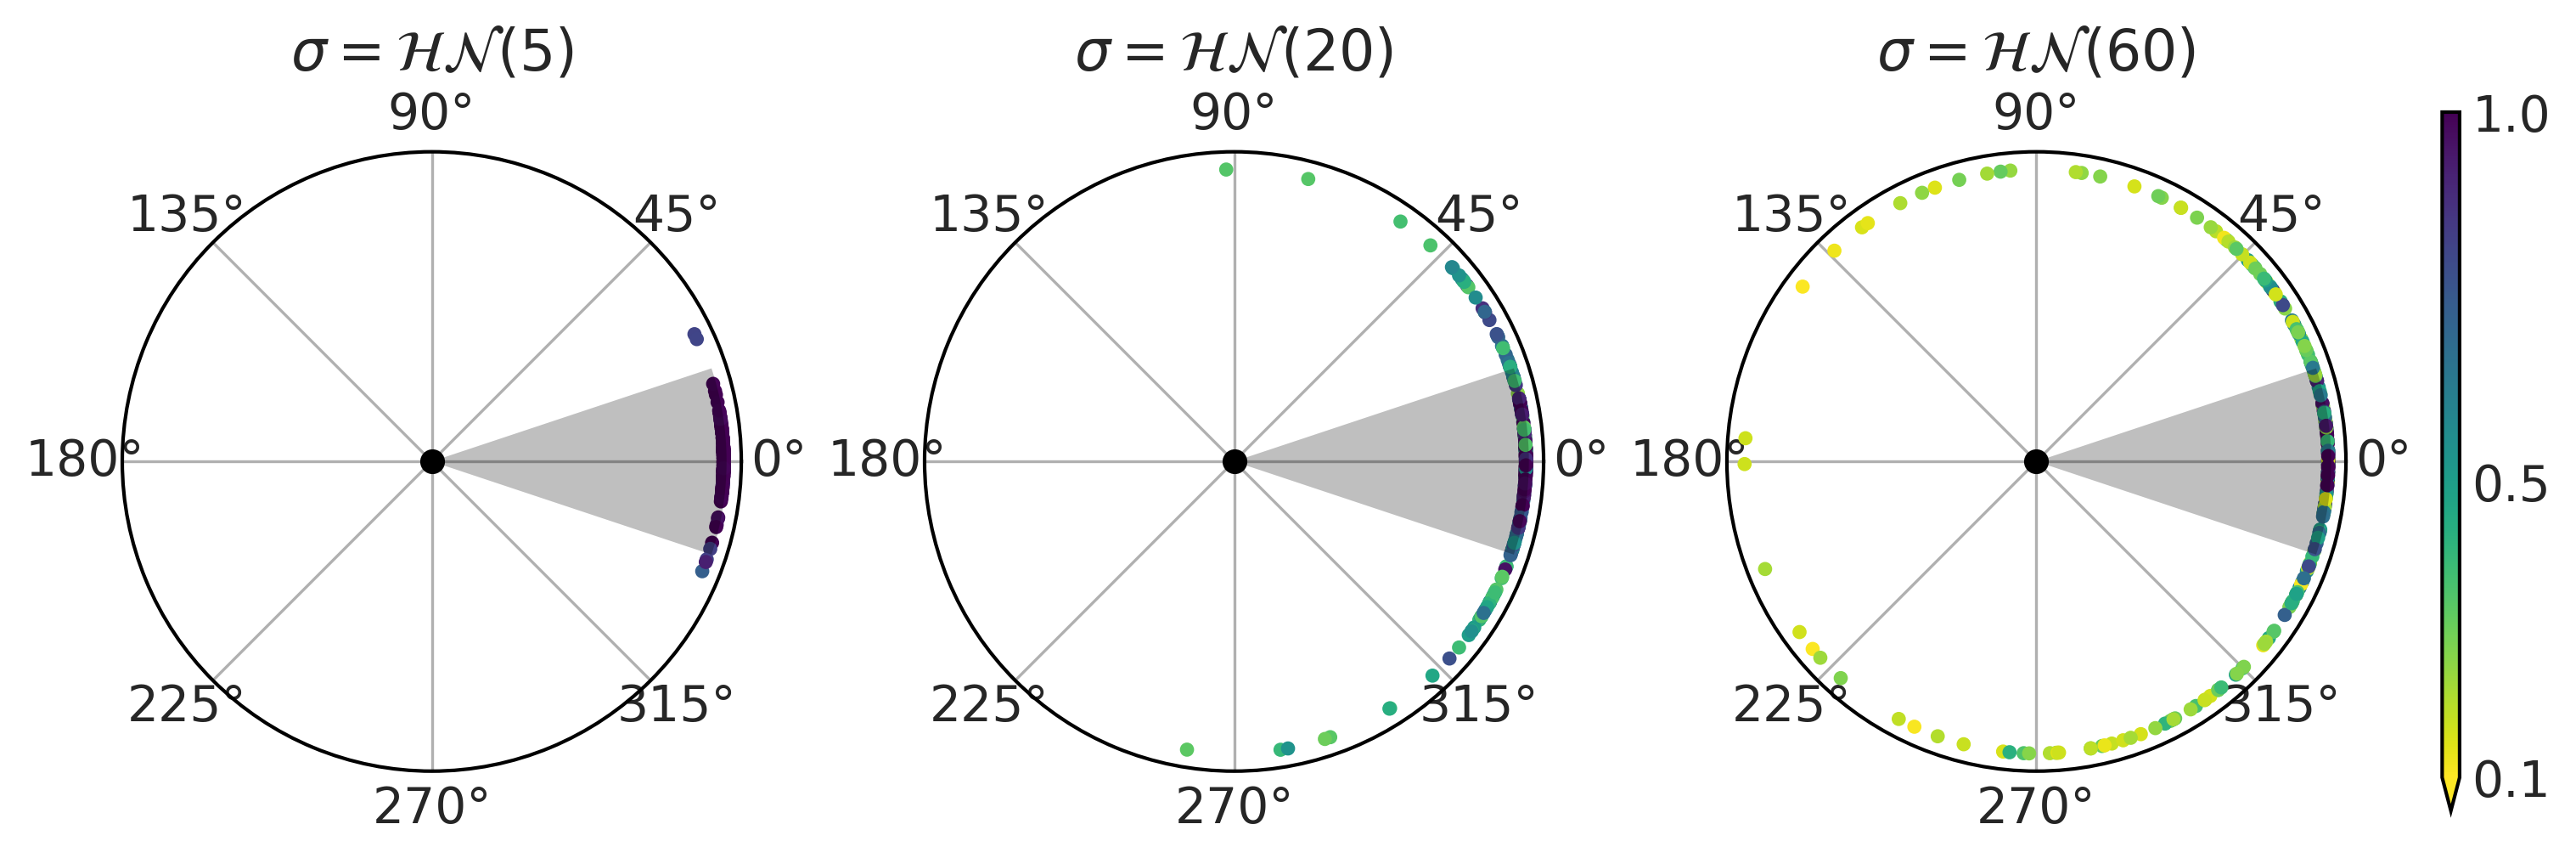

In [5]:
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection="polar"), figsize=(10, 4))

max_angle = np.arctan(half_length/penalty_point)

for sigma, pps, ax in zip(sigmas_deg, ppss, axes):
    cutoff = pps.prior["p_goal"] > (0.1)
    values = pps.prior["α"].where(cutoff)
    cax = ax.scatter(values, np.ones_like(values), c=pps.prior["p_goal"].where(cutoff),
                marker=".", cmap="viridis_r", vmin=0.1)
    ax.fill_between(np.linspace(-max_angle, max_angle, 100), 0, 1.01, alpha=0.25)
    ax.set_yticks([])
    ax.set_title(f"$\sigma = \mathcal{{HN}}({sigma})$")
    ax.plot(0, 0, 'o')
fig.colorbar(cax, extend="min", ticks=[1, 0.5, 0.1], shrink=0.7, aspect=40)

Text(0.34, -0.075, 'mean of the simulated data')

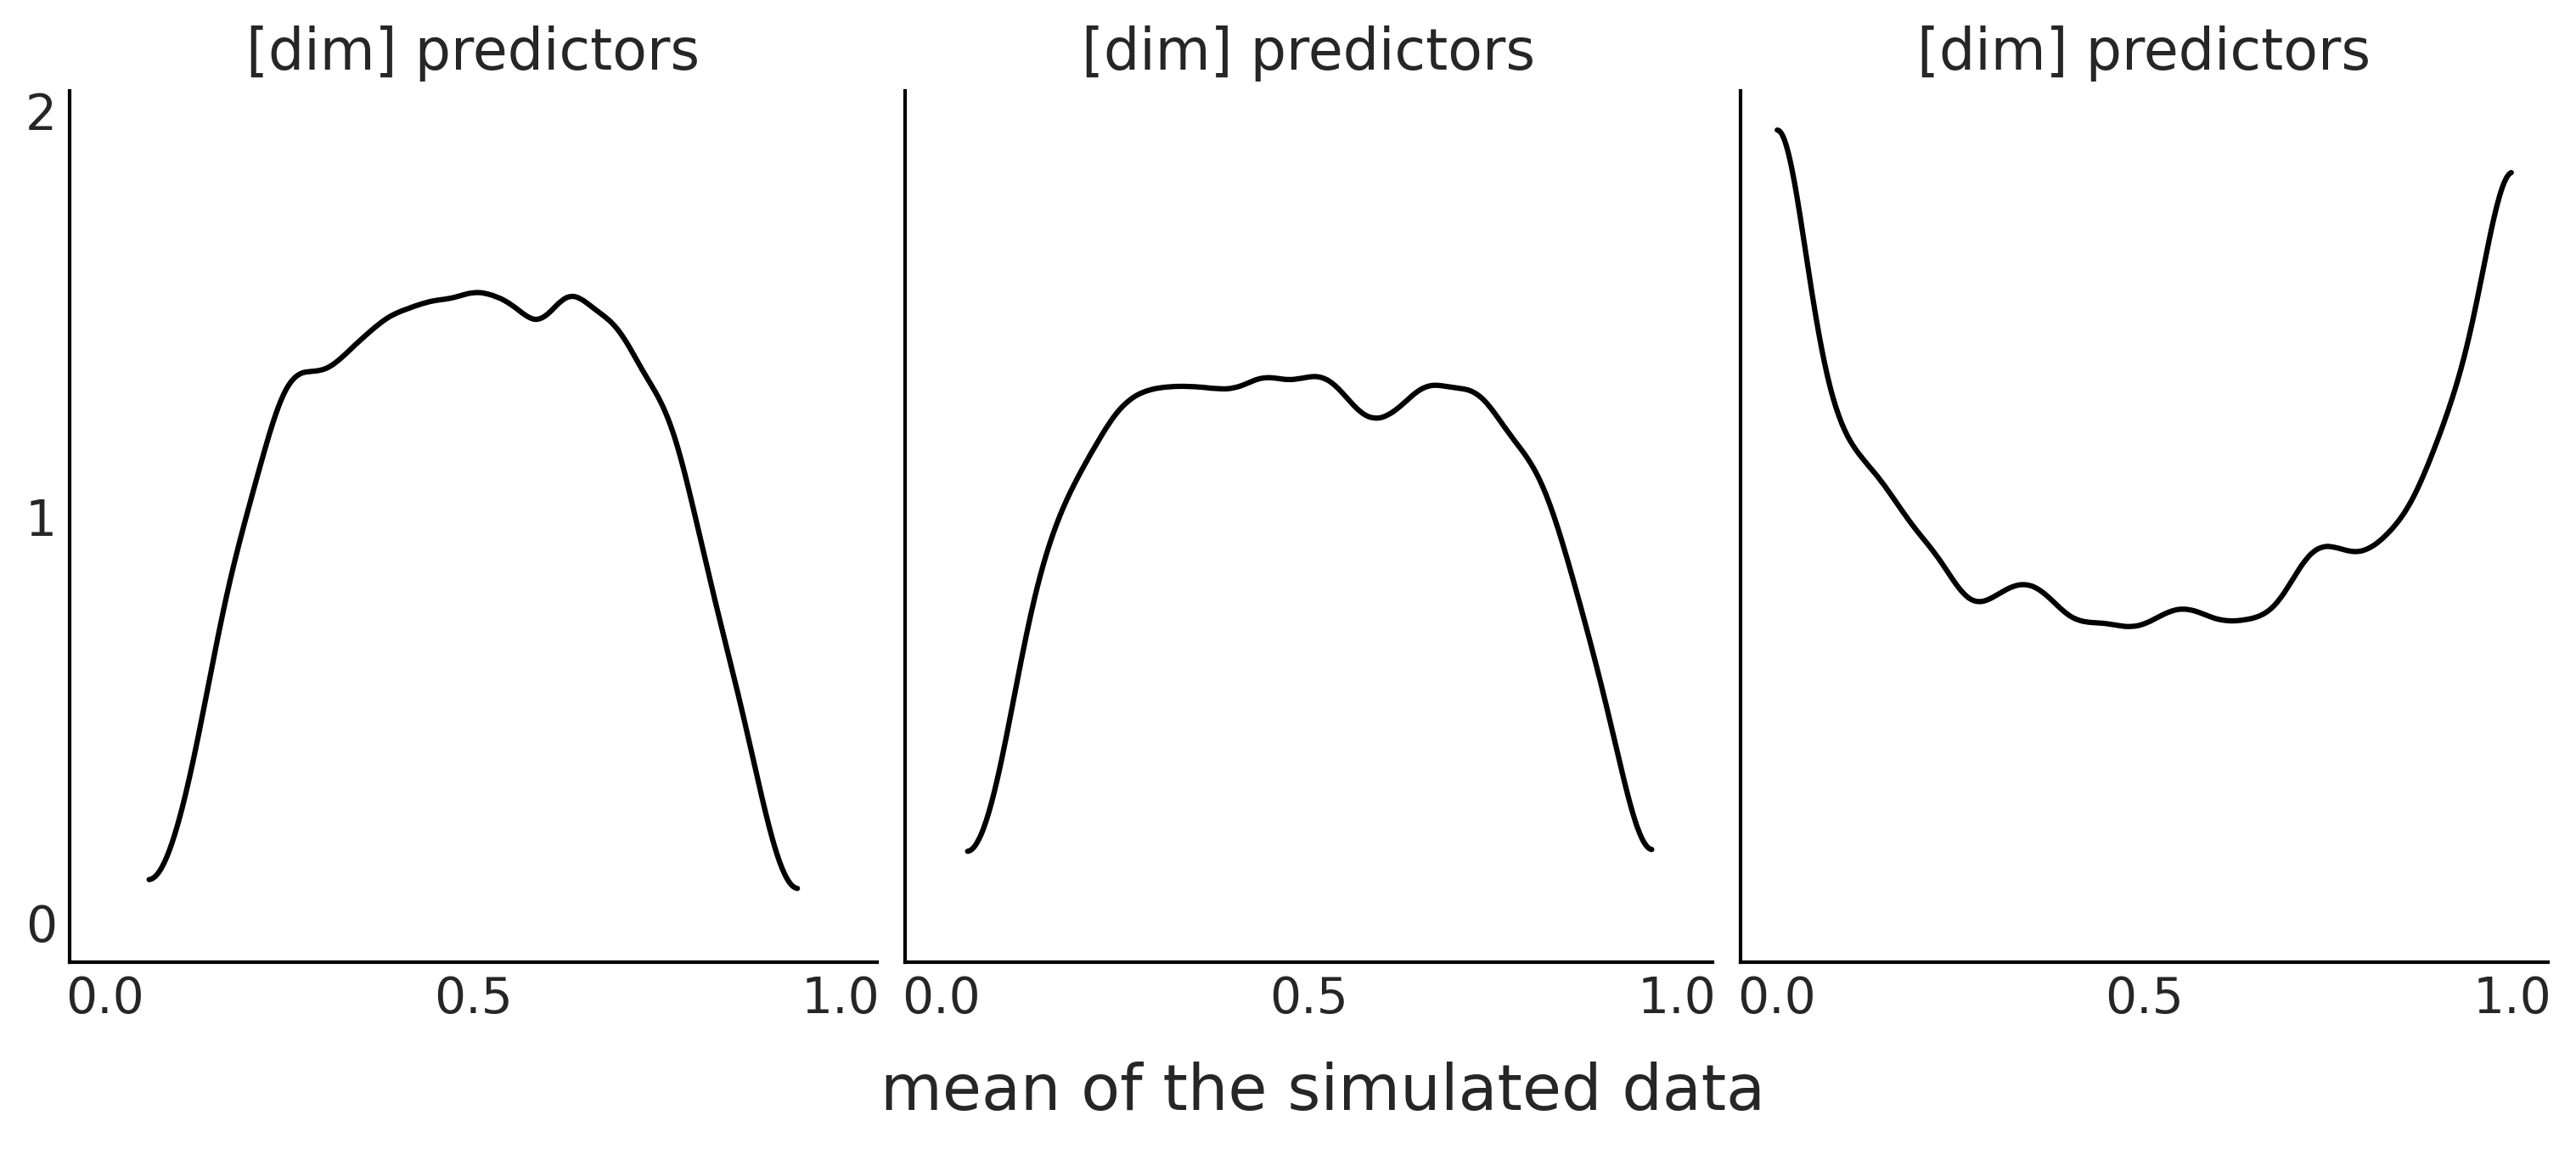

In [6]:
from scipy.special import expit

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
axes = np.ravel(axes)

for dim, ax in zip([2, 3, 20], axes):
    β = np.random.normal(0, 1, size=(10000, dim))
    X = np.random.binomial(n=1, p=0.75, size=(dim, 500))
    az.plot_kde(expit(β @ X).mean(1), ax=ax)
    ax.set_title(f"[dim] predictors")
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 1, 2])
    
fig.text(0.34, -0.075, size=18, s="mean of the simulated data")

In [7]:
Y = stats.bernoulli(0.7).rvs(100)
with pm.Model() as model:
    θ = pm.Beta("θ", 1, 1)
    y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)
    idata_b = pm.sample(1000)
    idata_b.extend(pm.sample_posterior_predictive(idata_b))

In [11]:
pred_dist = az.extract(idata_b, group="posterior_predictive", num_samples=1000)["y_obs"].values
pred_dist.sum(0).shape

(1000,)